In [35]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [36]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # MPS
print(f"Using {device} device")

root = './'
if not os.path.exists(root):
    os.makedirs(root)

Using mps device


In [37]:
# Data Transform (Normalization)
trans = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
# trans = transforms.Compose([transform.ToTensor(), transform.Normalize((0.5,),(1.0,))]) # x-u(뮤)/6(표준편차) 순서대로 각각 0.5, 1.0
# trans = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()])

# (DL Process) 1. Data Load
train_data = datasets.CIFAR10(
    root='./dataset',
    train=True,
    download=True,
    transform=trans,
)

test_data = datasets.CIFAR10(
    root='./dataset',
    train=False,
    download=True,
    transform=trans,
)


batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [38]:
# (DL Process) 2. Network 구성 (CNN)
# two convolution layers followed by two linear layers

class MyConvNet(nn.Module):   # nn.Module should be inherited for the neural network configuration so that it can work with backpropagation APIs
    def __init__(self):    # define layers: two conv layers and two linear (fully connected) layers
        super(MyConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), # 3 input channels, 64 filters, 3x3 kernel -> Output: 32x32x64 (34-3+1)
            nn.BatchNorm2d(64), # Batch Normalization
            nn.ReLU(),
            ## Conv Layer Twice
            nn.Conv2d(64, 64, 3, padding=1), # 64 input channels, 64 filters, 3x3 kernel -> Output: 32x32x64 (34-3+1)
            nn.BatchNorm2d(64), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 2x2 max-pooling -> Output: 16x16x64

            nn.Conv2d(64, 128, 3, padding=1), # 64 input channels, 128 filters, 3x3 kernel -> Output: 16x16x128 (18-3+1)
            nn.BatchNorm2d(128), # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), # 128 input channels, 128 filters, 3x3 kernel -> Output: 16x16x128 (18-3+1)
            nn.BatchNorm2d(128), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 2x2 max-pooling -> Output: 8x8x128

            nn.Conv2d(128, 256, 3, padding=1), # 128 input channels, 256 filters, 3x3 kernel -> Output: 8x8x256 (10-3+1)
            nn.BatchNorm2d(256), # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), # 256 input channels, 256 filters, 3x3 kernel -> Output: 8x8x256 (10-3+1)
            nn.BatchNorm2d(256), # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 2x2 max-pooling -> Output: 4x4x256

            nn.Flatten(), # flatten the output of the previous layer -> Output: 512x1
            nn.Dropout(0.5), # Dropout layer
            nn.Linear(4*4*256, 512), # Weights: 512x1024, Bias: 512x1
            nn.ReLU(),
            nn.Linear(512, 10) #  Weights: 10x512, Bias: 10x1
        )

    # network connection: two conv layers, each followed by relu and max-pooling with (2x2) kernel, and two linear layer
    def forward(self, x):
        logits = self.conv_layers(x) # forward propagation
        return(logits) # return the output of the network


# generate neural net model
model = MyConvNet().to(device) # CPU or GPU
print(model)

MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [39]:
# (DL Process) 3. Optimizer/Loss Function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # SGD (w/ scheduler)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1) # 30 epochs마다 lr(learning rate) 0.1 감소 (for convergence)

criterion = nn.CrossEntropyLoss()

In [40]:
# (DL Process) 4. Model Training & Test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(10):
    # training phase
    model.train() # 모델을 학습 모드로 전환
    current_loss= 0.0

    # train_loader: 데이터 로더에서 데이터를 가져옴
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device) # 학습을 위해 데이터를 디바이스에 올림

        out = model(x) # 모델에 데이터를 넣어 예측값을 얻음
        loss = criterion(out,target) # 예측값과 실제값의 차이를 계산 (Losss)

        optimizer.zero_grad() # 모델의 가중치를 초기화
        loss.backward() # Loss Back Propagation
        optimizer.step() # Weight Update
        current_loss += loss # Loss 값을 누적

        # Display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100)) # 100개의 배치마다 현재 에폭과 배치 번호, 현재 손실 값을 출력
            current_loss = 0.0 # 누적된 Loss 값을 초기화


    # test phase
    with torch.no_grad(): # 테스트 단계에서는 가중치 업데이트가 필요하지 않으므로 가중치 업데이트를 비활성화
        model.eval() # 모델을 평가 모드로 전환
        total_samples = 0.0 # 전체 샘플 수를 초기화
        correct_samples = 0.0 # 정확하게 분류된 샘플 수를 초기화

        for (x, target) in test_loader: # 테스트 데이터 로더에서 데이터를 가져옴
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1) # 예측값 중 가장 높은 값을 가진 클래스를 선택
            correct_samples += (pred == target).sum() # 정확하게 분류된 샘플 수를 누적 (sum 함수는 텐서의 모든 요소의 합을 계산)
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))

epoch: 0, batch_num: 100, current_loss: 1.943
epoch: 0, batch_num: 200, current_loss: 1.570
epoch: 0, batch_num: 300, current_loss: 1.398
Accuracy: 40.980
epoch: 1, batch_num: 100, current_loss: 1.177
epoch: 1, batch_num: 200, current_loss: 1.085
epoch: 1, batch_num: 300, current_loss: 1.004
Accuracy: 62.790
epoch: 2, batch_num: 100, current_loss: 0.899
epoch: 2, batch_num: 200, current_loss: 0.865
epoch: 2, batch_num: 300, current_loss: 0.834
Accuracy: 71.460
epoch: 3, batch_num: 100, current_loss: 0.756
epoch: 3, batch_num: 200, current_loss: 0.735
epoch: 3, batch_num: 300, current_loss: 0.724
Accuracy: 74.750
epoch: 4, batch_num: 100, current_loss: 0.672
epoch: 4, batch_num: 200, current_loss: 0.635
epoch: 4, batch_num: 300, current_loss: 0.640
Accuracy: 77.310
epoch: 5, batch_num: 100, current_loss: 0.586
epoch: 5, batch_num: 200, current_loss: 0.585
epoch: 5, batch_num: 300, current_loss: 0.598
Accuracy: 76.080
epoch: 6, batch_num: 100, current_loss: 0.537
epoch: 6, batch_num: 200

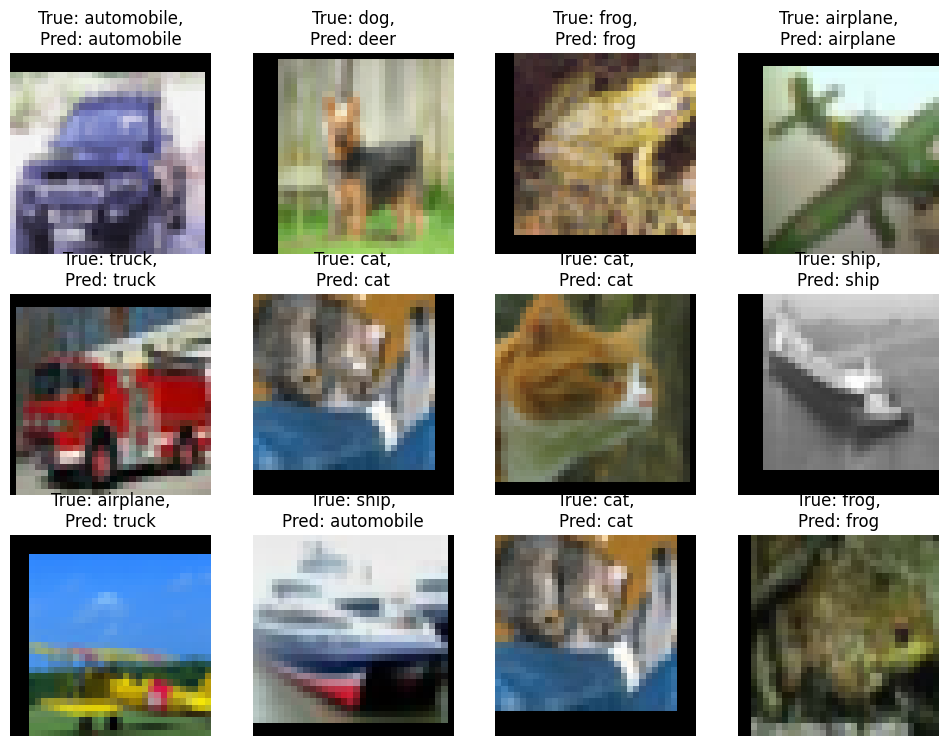

In [41]:
# Display Some test results
import numpy as np
import matplotlib.pyplot as plt

classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# take one batch of the data (Batch_size = 50)
test_data, test_labels = next(iter(test_loader))

# if cuda_available:
test_data, test_labels = test_data.to(device), test_labels.to(device) # move the data to GPU
out = model(test_data)              # put the test data to the trained network
pred = torch.argmax(out,1)          # prediction to the highest probability


sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size     # number of samples

random_samples = test_data[sample_index].cpu().numpy() # get the test data

plt.figure(figsize=(12, 12)) # set the figure size

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    # Reshape to (32, 32, 3) for RGB image
    plt.imshow(random_samples[k].transpose(1, 2, 0))  # Transpose to (height, width, channels)
    plt.title("True: " + str( classes[test_labels[sample_index[k]].item()]) + ",\nPred: " + str(classes[pred[sample_index[k]].item()]))
    plt.axis('off')


plt.show()

In [42]:
# save model
torch.save(model, root + 'CNN_CIFAR10.pth')

# load model
# model = torch.load('my_CNN_model.pth')